In [1]:
#Code to calculate the contour plots for A, B and intrinsic scatter (sigma) for T90 
# using emcee and plotting them with corner package.


#This code finds out the marginalized contours for the parameters A and B of our model (y=Ax^B) where y is T90 and x is (1+z)
# or z depending on the type of analysis performed.


#Importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii


from scipy import stats
#import pickle
#from sympy.solvers import solve
from scipy import optimize, interpolate
from scipy.integrate import quad
#import bces.bces
import emcee
from time import time    
from math import log
import corner

In [2]:
#Importing the binned data and storing it into pandas dataframe

legend_properties = {'weight':'bold'}


data=pd.read_excel('Weighted mean burst interval data 6 bins.xlsx')
 



In [3]:
data

,z_mean,z_err,T90_WM,T90_WM_error,T50_WM,T50_WM_error
0,0.778083,0.661083,0.462355,0.015048,0.510104,0.009861
1,2.100250,0.661083,6.405263,0.084405,4.731303,0.055622
2,3.422417,0.661083,16.826313,0.338812,5.735303,0.103964
3,4.744583,0.661083,12.693091,0.503496,7.722997,0.331179
4,6.066750,0.661083,42.610954,1.050181,26.943567,3.778623
5,7.388917,0.661083,12.960000,2.808000,5.296000,0.581000


-117.22822217811176


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]D:\Anaconda3\envs\GW\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▊                                                                                 | 4/400 [00:00<00:27, 14.53it/s]

[2.58612199 1.10562082 2.31192296]
-17.106493598089788


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:09<00:00,  5.72it/s]
D:\Anaconda3\envs\GW\lib\site-packages\corner\core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
D:\Anaconda3\envs\GW\lib\site-packages\corner\core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)
D:\Anaconda3\envs\GW\lib\site-packages\corner\core.py:675: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(X2, Y2, H2.T, V, **contour_kwargs)


Time taken to run 'emcee' is 69.99705290794373 seconds
(20000, 3)
4.378482080684131 3.2717107633744322 3.751219671896239 A
0.7368760949450227 0.4902541389135219 0.7166268846171627 B
2.511694701822073 0.40262004548330577 0.4175687507049455 ln($\sigma_{int}$)
[4.37848208 0.73687609 2.5116947 ]
-17.468621769889463


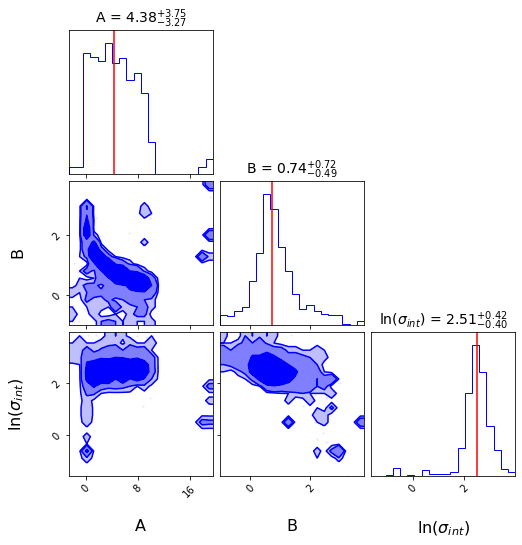

In [4]:
#Assigning variables to our input data and converting them into float for easy analysis.

x=(data['z_mean']).astype(float)
xerr=(data['z_err']).astype(float)
y=(data['T90_WM']).astype(float)
yerr=(data['T90_WM_error']).astype(float)


#curve fit
#def f(r1,m,c):
 #return m*r1+c

i=2
nboot=10000


def logl(params):
    A,B,logf=params      # A, B and logf are the parameters to be optimized
    model = A*((1+x)**B)   # Our model 
    f=np.exp(logf)
    #sig_i=(eat/at)**2+(m*(eab/ab))**2+sig**2
    #return -0.5 * np.sum((np.log(at) - (m*np.log(ab)+c)) ** 2 / sig_i  + np.log(sig_i))

    sigma2 = yerr ** 2  + ((A*B* (1+x) ** (B-1)) ** 2) * (xerr)**2 +f**2    #binned data
    return -0.5 * np.sum((y-model) ** 2 / sigma2  + np.log(sigma2))         #This returns the log likelihood 



   

def log_prior(params):
    A, B,logf = params
    if -3 < A < 10 and -1 < B < 3 and -1 < logf < 4:    # Priors for our parameters A, B and C. 
        return 0.0                                      # These priors can be fiddled around to obtain closed contours.
    return -np.inf

def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logl(params)

v2=np.array([11,1,0.1])
print (logl(v2))
   
Nens = 100 
mini = np.random.uniform(-0.5, 20, Nens)
bini=np.random.uniform(0, 4, Nens)
sini=np.random.uniform(-2,2,Nens)
params=[10.97,1,-1]
neg_logl = lambda theta: -logl(theta)
result=optimize.minimize(neg_logl,params)    #optimizing the model and storing the resultant parameters in result variable.
print (result.x)
print (logl(result.x))

inisamples = np.array([mini, bini,sini]).T # initial samples
ndims = inisamples.shape[1] # number of parameters/dimensions
Nburnin = 200   # number of burn-in samples
Nsamples = 200  # number of final posterior samples
sampler = emcee.EnsembleSampler(Nens, ndims, log_posterior)
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin,progress=True);
t1 = time()
timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
labels=["A", "B", "ln($\sigma_{int}$)"]
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))
print (samples_emcee.shape)
#tau = sampler.get_autocorr_time()
#print(tau)
flat_samples = sampler.get_chain(discard=Nburnin, thin=15, flat=True)

#FF = open("tempnopcut.pkl", "wb")
#pickle.dump(flat_samples,FF)
#FF.close()

value2 = np.median(flat_samples, axis=0)
fig = corner.corner(flat_samples, labels=labels, levels=(0.68,0.95,0.99),color = 'b',alpha=0.1,fill_contours = 1,show_titles=True,title_fmt='.2f',max_n_ticks = 3, title_kwargs={"fontsize": 14},label_kwargs={"fontsize": 16},contour_kwargs={"color": 'r'})
# Extract the axes
axes = np.array(fig.axes).reshape((ndims, ndims))

# Loop over the diagonal
for i in range(ndims):
 ax = axes[i, i]
 ax.axvline(value2[i], color="r")

 
ax = axes[1,0]
#ax.axvline(x=0.0, color="k", linestyle='--')
#ax.axhline(y=1.0, color="k", linestyle='--')
         
plt.savefig("contour_T90_vs_(1+z)_6_binned.pdf")
v=np.zeros(ndims)
for i in range(ndims):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    v[i]=mcmc[1]
    q = np.diff(mcmc)
    print (mcmc[1],q[0],q[1],labels[i] )

print (v)
print (logl(v))
exit(0)

